In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Surrogate approx

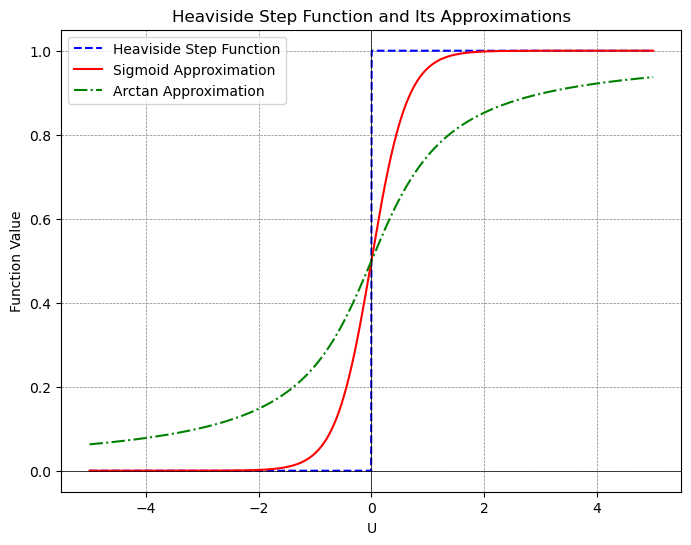

In [2]:
# Define Heaviside step function
def heaviside_step(U):
    return np.where(U >= 0, 1, 0)

# Define sigmoid approximation
def sigmoid_approx(U, beta=np.pi, theta=0):
    return 1 / (1 + np.exp(-beta * (U - theta)))

# Define arctan derivative approximation
def arctan_approx(U, beta=1, theta=0):
    return 0.5 + (1 / np.pi) * np.arctan(beta * (U - theta))

# Generate U values
U_values = np.linspace(-5, 5, 1000)

# Calculate Heaviside step function
heaviside_result = heaviside_step(U_values)

# Calculate sigmoid approximation
sigmoid_result = sigmoid_approx(U_values)

# Calculate arctan approximation
arctan_result = arctan_approx(U_values)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(U_values, heaviside_result, label='Heaviside Step Function', linestyle='--', color='blue')
plt.plot(U_values, sigmoid_result, label='Sigmoid Approximation', color='red')
plt.plot(U_values, arctan_result, label='Arctan Approximation', linestyle='-.', color='green')

# Adding labels and annotations
plt.title('Heaviside Step Function and Its Approximations')
plt.xlabel('U')
plt.ylabel('Function Value')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

## Encoding part

In [3]:
# Checking that the rate encodings of the MNIST image, if averaged, can return something close to the original image
import numpy as np
import matplotlib.pyplot as plt
import snntorch as snn
from snntorch import utils
import torch
import os
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

In [4]:
# Training Parameters
batch_size=1
data_path = './data'
os.makedirs(data_path, exist_ok=True)
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float

from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)



subset = 10
mnist_train = utils.data_subset(mnist_train, subset)
print(f"The size of mnist_train is {len(mnist_train)}")
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

The size of mnist_train is 6000


Data shape: torch.Size([1, 1, 28, 28]) Targets shape: torch.Size([1])
Spike Data shape: torch.Size([2, 1, 1, 28, 28])  (Time, Batch, Channels, Height, Width)


Text(0.5, 1.0, 'Average Spikes over 100 Timesteps')

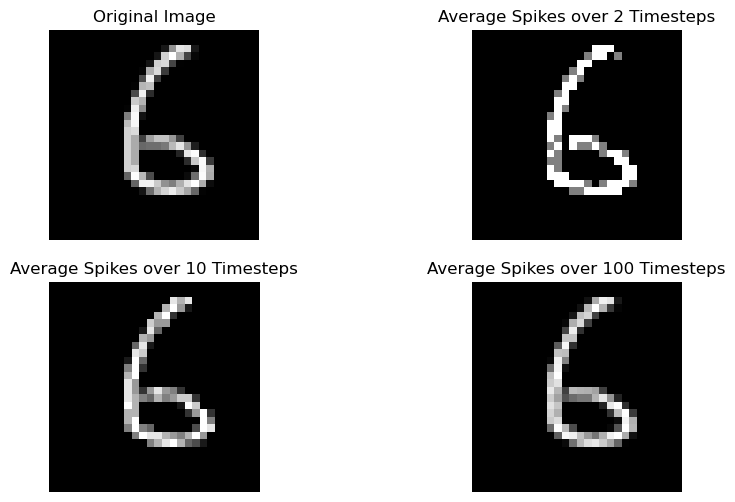

In [5]:
from snntorch import spikegen

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

print(f"Data shape: {data_it.shape}", f"Targets shape: {targets_it.shape}")

num_steps = 2
num_steps_2 = 10
num_steps_3 = 100
# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)
spike_data_2 = spikegen.rate(data_it, num_steps=num_steps_2)
spike_data_3 = spikegen.rate(data_it, num_steps=num_steps_3)

print(f"Spike Data shape: {spike_data.shape}", " (Time, Batch, Channels, Height, Width)")

spike_data_sample = spike_data[:, 0, 0]
spike_data_sample_2 = spike_data_2[:, 0, 0]
spike_data_sample_3 = spike_data_3[:, 0, 0]

# Plotting
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.imshow(data_it[0, 0], cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='gray')
plt.axis('off')
plt.title(f'Average Spikes over {num_steps} Timesteps')
plt.subplot(2, 2, 3)
plt.imshow(spike_data_sample_2.mean(axis=0).reshape((28,-1)).cpu(), cmap='gray')
plt.axis('off')
plt.title(f'Average Spikes over {num_steps_2} Timesteps')
plt.subplot(2, 2, 4)
plt.imshow(spike_data_sample_3.mean(axis=0).reshape((28,-1)).cpu(), cmap='gray')
plt.axis('off')
plt.title(f'Average Spikes over {num_steps_3} Timesteps')



## LiF model tests

In [65]:
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

The decay rate is: 0.819


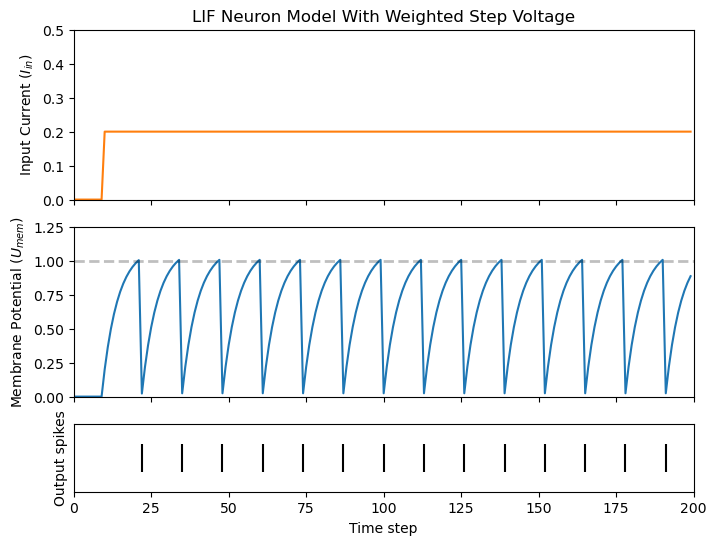

In [75]:
def leaky_integrate_and_fire(mem, x, w, beta, threshold=1):
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = beta * mem + w*x - spk*threshold
  return spk, mem

# set neuronal parameters
delta_t = torch.tensor(1e-3)
tau = torch.tensor(5e-3)
beta = torch.exp(-delta_t/tau)
print(f"The decay rate is: {beta:.3f}")

num_steps = 200

# initialize inputs/outputs + small step current input
x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = []
spk_rec = []

# parameters
w = 0.4
beta = 0.819

# classsnntorch._neurons.leaky.Leaky(beta, threshold=1.0, spike_grad=None, surrogate_disable=False, init_hidden=False, inhibition=False, learn_beta=False, learn_threshold=False, reset_mechanism='subtract', state_quant=False, output=False, graded_spikes_factor=1.0, learn_graded_spikes_factor=False, reset_delay=True)[source]
lif = snn.Leaky(beta, threshold=1.0, reset_mechanism='subtract')
# neuron simulation
for step in range(num_steps):
  spk, mem = leaky_integrate_and_fire(mem, x[step], w=w, beta=beta)
  
  # spk, mem = lif(x[step], mem) ?????????
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1,ylim_max1=0.5,
                 title="LIF Neuron Model With Weighted Step Voltage")